In [ ]:
# Import finance API and get historical stock data

import yfinance as yf
import os
import json
import pandas as pd

DATA_PATH = "msft_data.json"

if os.path.exists(DATA_PATH):
    # Read from file if we've already downloaded the data.
    with open(DATA_PATH) as f:
        msft_hist = pd.read_json(DATA_PATH)
else:
    msft = yf.Ticker("MSFT")
    msft_hist = msft.history(period="max")

    # Save file to json in case we need it later.  This prevents us from having to re-download it every time.
    msft_hist.to_json(DATA_PATH)

In [ ]:
# Display microsoft stock price history so we can look at the structure of the data
msft_hist.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13 00:00:00-05:00,0.054893,0.062965,0.054893,0.060274,1031788800,0.0,0.0
1986-03-14 00:00:00-05:00,0.060274,0.063504,0.060274,0.062427,308160000,0.0,0.0
1986-03-17 00:00:00-05:00,0.062427,0.064042,0.062427,0.063504,133171200,0.0,0.0
1986-03-18 00:00:00-05:00,0.063504,0.064042,0.061350,0.061889,67766400,0.0,0.0
1986-03-19 00:00:00-05:00,0.061889,0.062427,0.060274,0.060812,47894400,0.0,0.0


<Axes: xlabel='Date'>

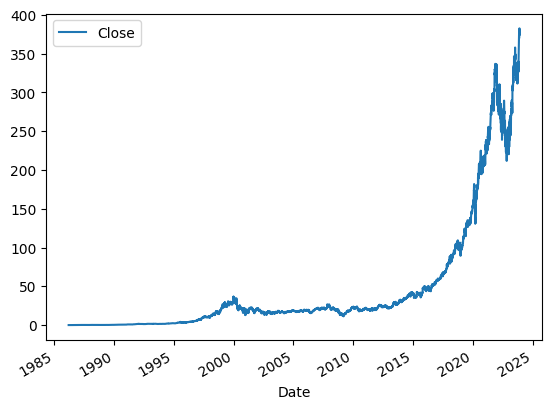

In [ ]:
# Visualize microsoft stock prices
msft_hist.plot.line(y="Close", use_index=True)

In [ ]:
# Ensure we know the actual closing price
data = msft_hist[["Close"]]
data = data.rename(columns = {'Close':'Actual_Close'})

# Setup our target.  This identifies if the price went up or down
data["Target"] = msft_hist.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]

In [ ]:
# Shift stock prices forward one day, so we're predicting tomorrow's stock prices from today's prices.
msft_prev = msft_hist.copy()
msft_prev = msft_prev.shift(1)

In [ ]:
# Create our training data
predictors = ["Close", "Volume", "Open", "High", "Low"]
data = data.join(msft_prev[predictors]).iloc[1:]

In [ ]:
data.head(5)

,Actual_Close,Target,Close,Volume,Open,High,Low
Date,,,,,,,
1986-03-14 00:00:00-05:00,0.062427,1.0,0.060274,1.031789e+09,0.054893,0.062965,0.054893
1986-03-17 00:00:00-05:00,0.063504,1.0,0.062427,3.081600e+08,0.060274,0.063504,0.060274
1986-03-18 00:00:00-05:00,0.061889,0.0,0.063504,1.331712e+08,0.062427,0.064042,0.062427
1986-03-19 00:00:00-05:00,0.060812,0.0,0.061889,6.776640e+07,0.063504,0.064042,0.061350
1986-03-20 00:00:00-05:00,0.059198,0.0,0.060812,4.789440e+07,0.061889,0.062427,0.060274


Backtesting

In [ ]:
weekly_mean = data.rolling(7).mean()
quarterly_mean = data.rolling(90).mean()
annual_mean = data.rolling(365).mean()
weekly_trend = data.shift(1).rolling(7).mean()["Target"]

In [ ]:
data["weekly_mean"] = weekly_mean["Close"] / data["Close"]
data["quarterly_mean"] = quarterly_mean["Close"] / data["Close"]
data["annual_mean"] = annual_mean["Close"] / data["Close"]

data["annual_weekly_mean"] = data["annual_mean"] / data["weekly_mean"]
data["annual_quarterly_mean"] = data["annual_mean"] / data["quarterly_mean"]
data["weekly_trend"] = weekly_trend

data["open_close_ratio"] = data["Open"] / data["Close"]
data["high_close_ratio"] = data["High"] / data["Close"]
data["low_close_ratio"] = data["Low"] / data["Close"]

In [ ]:
ma_100_days = data.rolling(100).mean()

In [ ]:
data["100_days_closing_mean"] = ma_100_days["Close"] / data["Close"]

In [ ]:
ma_200_days = data.rolling(200).mean()

In [ ]:
ma_300_days = data.rolling(300).mean()

In [ ]:
data["200_days_closing_mean"] = ma_200_days["Close"] / data["Close"]

In [ ]:
data["300_days_closing_mean"] = ma_300_days["Close"] / data["Close"]

In [ ]:
data.iloc[365:]

,Actual_Close,Target,Close,Volume,Open,High,Low,weekly_mean,quarterly_mean,annual_mean,annual_weekly_mean,annual_quarterly_mean,weekly_trend,open_close_ratio,high_close_ratio,low_close_ratio,100_days_closing_mean,200_days_closing_mean,300_days_closing_mean
Date,,,,,,,,,,,,,,,,,,,
1987-08-24 00:00:00-04:00,0.240559,1.0,0.230334,68976000.0,0.226028,0.233025,0.226028,0.971962,0.976310,0.558965,0.575089,0.572528,0.714286,0.981307,1.011681,0.981307,0.967733,0.781857,0.618099
1987-08-25 00:00:00-04:00,0.247017,1.0,0.240559,97747200.0,0.230334,0.241635,0.227104,0.941834,0.936378,0.537234,0.570413,0.573737,0.714286,0.957495,1.004474,0.944070,0.928456,0.751633,0.594213
1987-08-26 00:00:00-04:00,0.248632,1.0,0.247017,185961600.0,0.242711,0.251322,0.240021,0.931216,0.913470,0.525224,0.564019,0.574977,0.714286,0.982569,1.017428,0.971677,0.905903,0.735054,0.581096
1987-08-27 00:00:00-04:00,0.249170,1.0,0.248632,114105600.0,0.247017,0.254013,0.245940,0.939084,0.909439,0.523871,0.557853,0.576038,0.714286,0.993507,1.021644,0.989176,0.901384,0.733441,0.579754
1987-08-28 00:00:00-04:00,0.258857,1.0,0.249170,72432000.0,0.248631,0.250246,0.245940,0.953409,0.909251,0.524811,0.550457,0.577191,0.857143,0.997840,1.004319,0.987039,0.900863,0.735010,0.580932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-27 00:00:00-05:00,378.609985,1.0,377.429993,10176600.0,377.329987,377.970001,375.140015,0.992229,0.886034,0.754071,0.759977,0.851063,0.571429,0.999735,1.001431,0.993933,0.887885,0.834006,0.766432
2023-11-28 00:00:00-05:00,382.700012,1.0,378.609985,22179200.0,376.779999,380.640015,376.200012,0.992510,0.884246,0.752716,0.758396,0.851251,0.571429,0.995167,1.005362,0.993635,0.886141,0.832956,0.765247
2023-11-29 00:00:00-05:00,378.850006,0.0,382.700012,20453100.0,378.350006,383.000000,378.160004,0.984341,0.875968,0.745633,0.757495,0.851211,0.571429,0.988633,1.000784,0.988137,0.877896,0.825647,0.758297


In [ ]:
import numpy as np
dataset = data.values
training_data_len = int(np.ceil( len(dataset) * .95 ))

In [ ]:
training_data_len

9032

In [ ]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[1.68761344e-05, 1.00000000e+00, 1.12507466e-05, ...,
                   nan,            nan,            nan],
       [1.96903617e-05, 1.00000000e+00, 1.68761344e-05, ...,
                   nan,            nan,            nan],
       [1.54697412e-05, 0.00000000e+00, 1.96903617e-05, ...,
                   nan,            nan,            nan],
       ...,
       [9.89938414e-01, 0.00000000e+00, 1.00000000e+00, ...,
        3.18439408e-01, 2.96015961e-01, 2.08930453e-01],
       [9.90095211e-01, 1.00000000e+00, 9.89938414e-01, ...,
        3.28842324e-01, 3.03790894e-01, 2.14910402e-01],
       [9.78596289e-01, 0.00000000e+00, 9.90095211e-01, ...,
        3.29986033e-01, 3.04824101e-01, 2.15669771e-01]])

In [ ]:
# Create the training data set
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

[array([1.68761344e-05, 1.96903617e-05, 1.54697412e-05, 1.26570424e-05,
       8.43800881e-06, 4.21900440e-06, 0.00000000e+00, 2.81269881e-06,
       7.03165453e-06, 9.84435334e-06, 8.43800881e-06, 7.03165453e-06,
       8.43800881e-06, 9.84435334e-06, 9.84435334e-06, 7.03165453e-06,
       8.43800881e-06, 1.12507466e-05, 1.26570424e-05, 1.54697412e-05,
       1.68761344e-05, 1.68761344e-05, 2.25030508e-05, 2.39093272e-05,
       1.82840269e-05, 1.82840269e-05, 1.54697412e-05, 1.61728599e-05,
       3.23474139e-05, 4.35997279e-05, 4.50061990e-05, 3.93792242e-05,
       3.51600835e-05, 3.23474139e-05, 3.23474139e-05, 3.09410596e-05,
       3.23474139e-05, 3.23474139e-05, 3.37537876e-05, 3.23474139e-05,
       3.37537876e-05, 3.51600835e-05, 3.37537876e-05, 3.37537876e-05,
       3.51600835e-05, 3.23474139e-05, 3.09410596e-05, 2.81284874e-05,
       2.81284874e-05, 2.81284874e-05, 3.37537876e-05, 3.93792242e-05,
       4.35997279e-05, 5.06314993e-05, 4.50061990e-05, 4.50061990e-05,
     

In [ ]:
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

In [ ]:
model = Sequential()
model.add(LSTM(units = 50, activation = 'relu', return_sequences = True,
               input_shape= (x_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 60, activation='relu', return_sequences = True))
model.add(Dropout(0.3))

model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
model.add(Dropout(0.4))

model.add(LSTM(units = 120, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(units =1))

In [ ]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
model.fit(x_train, y_train, batch_size=32, epochs=20)

Epoch 1/20
281/281 [==============================] - 68s 221ms/step - loss: 0.0027
Epoch 2/20
281/281 [==============================] - 56s 199ms/step - loss: 0.0013
Epoch 3/20
281/281 [==============================] - 56s 199ms/step - loss: 9.1192e-04
Epoch 4/20
281/281 [==============================] - 55s 194ms/step - loss: 9.6182e-04
Epoch 5/20
281/281 [==============================] - 55s 197ms/step - loss: 8.1302e-04
Epoch 6/20
281/281 [==============================] - 56s 198ms/step - loss: 7.6308e-04
Epoch 7/20
281/281 [==============================] - 54s 193ms/step - loss: 7.0070e-04
Epoch 8/20
281/281 [==============================] - 55s 195ms/step - loss: 7.0328e-04
Epoch 9/20
281/281 [==============================] - 56s 198ms/step - loss: 7.0888e-04
Epoch 10/20
281/281 [==============================] - 56s 198ms/step - loss: 7.5286e-04
Epoch 11/20
281/281 [==============================] - 53s 190ms/step - loss: 6.4631e-04
Epoch 12/20
281/281 [=================

In [ ]:
scaler.scale_

array([2.61339492e-03, 1.00000000e+00, 2.61339492e-03, 9.71359655e-10,
       2.60616801e-03, 2.60252015e-03, 2.64476721e-03, 1.59096415e+00,
       1.06167201e+00, 6.42109082e-01, 7.37847572e-01, 1.19830050e+00,
       1.00000000e+00, 2.01921654e+00, 2.47945294e+00, 7.34612845e+00,
       1.02001188e+00, 7.90043294e-01, 6.69580203e-01])

In [ ]:
#scale_factor = 1/0.00261339
scaler = scaler.scale_
scale_factor = 1/scaler[0]

In [ ]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values
predictions = model.predict(x_test)
#predictions = scaler.inverse_transform(predictions)
#predictions = predictions * scale_factor
# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

15/15 [==============================] - 1s 48ms/step


7228909.38009807

In [ ]:
y_predicted = predictions * scale_factor
y_test = y_test * scale_factor

<ipython-input-97-47c2258f587a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = y_predicted


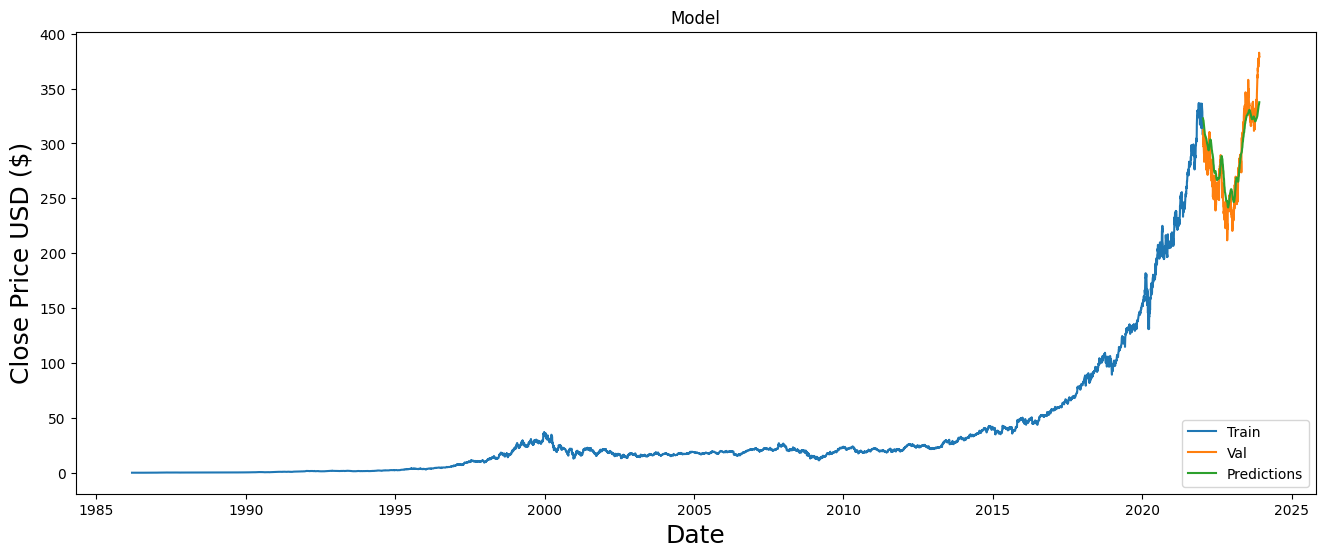

In [ ]:
import matplotlib.pyplot as plt
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = y_predicted
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
# Show the valid and predicted prices
valid

,Actual_Close,Target,Close,Volume,Open,High,Low,weekly_mean,quarterly_mean,annual_mean,annual_weekly_mean,annual_quarterly_mean,weekly_trend,open_close_ratio,high_close_ratio,low_close_ratio,100_days_closing_mean,200_days_closing_mean,300_days_closing_mean,Predictions
Date,,,,,,,,,,,,,,,,,,,,
2022-01-12 00:00:00-05:00,312.544128,1.0,309.313385,29386800.0,307.742164,310.914035,304.314960,1.014717,1.008490,0.817059,0.805208,0.810180,0.428571,0.994920,1.005175,0.983840,1.003373,0.919679,0.849993,322.858429
2022-01-13 00:00:00-05:00,299.316467,0.0,312.544128,34372200.0,313.918966,317.591671,311.375535,0.996831,0.998682,0.809513,0.812087,0.810581,0.571429,1.004399,1.016150,0.996261,0.993456,0.911552,0.842402,322.340149
2022-01-14 00:00:00-05:00,304.619354,1.0,299.316467,45366000.0,314.704568,315.107196,298.530872,1.029537,1.043006,0.846136,0.821861,0.811248,0.571429,1.051411,1.052756,0.997375,1.037383,0.952992,0.880622,321.756165
2022-01-18 00:00:00-05:00,297.205109,0.0,304.619354,39846400.0,298.776386,305.228195,298.285381,1.008769,1.025226,0.832290,0.825056,0.811811,0.714286,0.980819,1.001999,0.979207,1.019586,0.937519,0.866252,321.072723
2022-01-19 00:00:00-05:00,297.872864,1.0,297.205109,42333200.0,298.599575,304.226469,296.311477,1.028633,1.051020,0.853860,0.830092,0.812411,0.714286,1.004692,1.023625,0.996993,1.045061,0.961817,0.888759,320.319550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-27 00:00:00-05:00,378.609985,1.0,377.429993,10176600.0,377.329987,377.970001,375.140015,0.992229,0.886034,0.754071,0.759977,0.851063,0.571429,0.999735,1.001431,0.993933,0.887885,0.834006,0.766432,335.436279
2023-11-28 00:00:00-05:00,382.700012,1.0,378.609985,22179200.0,376.779999,380.640015,376.200012,0.992510,0.884246,0.752716,0.758396,0.851251,0.571429,0.995167,1.005362,0.993635,0.886141,0.832956,0.765247,336.049683
2023-11-29 00:00:00-05:00,378.850006,0.0,382.700012,20453100.0,378.350006,383.000000,378.160004,0.984341,0.875968,0.745633,0.757495,0.851211,0.571429,0.988633,1.000784,0.988137,0.877896,0.825647,0.758297,336.597260


In [ ]:
model.save('stock_prediction_model.h5')

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 60)            26640     
                                                                 
 dropout_1 (Dropout)         (None, 60, 60)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 80)            45120     
                                                                 
 dropout_2 (Dropout)         (None, 60, 80)            0         
                                                                 
 lstm_3 (LSTM)               (None, 120)              